# Section 1: Image Registry Preparation

## Overview
In few-shot learning, organizing and tracking our dataset is crucial. This section focuses on creating an **image registry** - a CSV file that maps each image to its corresponding class label.

## Purpose
The image registry will contain:
- **Column 1**: Image path (relative or absolute path to each image file)
- **Column 2**: Class label (derived from the subfolder name in the `images/` directory)

This structured registry makes it easy to:
- Load and organize images for training and testing
- Track which images belong to which classes
- Implement data splits for few-shot learning tasks
- Maintain reproducibility in experiments

In [1]:
import os
import csv
from pathlib import Path
from typing import List, Tuple


class ImageRegistryBuilder:
    """
    A class to build an image registry from a directory structure.
    
    The registry maps image file paths to their corresponding class labels,
    where class labels are derived from subfolder names.
    """
    
    def __init__(self, root_dir: str, image_extensions: List[str] = None):
        """
        Initialize the ImageRegistryBuilder.
        
        Args:
            root_dir: Root directory containing class subfolders
            image_extensions: List of valid image file extensions (default: common formats)
        """
        self.root_dir = Path(root_dir)
        if image_extensions is None:
            self.image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
        else:
            self.image_extensions = image_extensions
        
        self.registry_data: List[Tuple[str, str]] = []
    
    def _is_image_file(self, filename: str) -> bool:
        """Check if a file is an image based on its extension."""
        return any(filename.lower().endswith(ext) for ext in self.image_extensions)
    
    def scan_directory(self) -> None:
        """
        Scan the root directory and collect image paths with their labels.
        
        The directory structure should be:
            root_dir/
                class1/
                    image1.jpg
                    image2.jpg
                class2/
                    image3.jpg
        """
        if not self.root_dir.exists():
            raise ValueError(f"Root directory does not exist: {self.root_dir}")
        
        self.registry_data.clear()
        
        # Iterate through subdirectories (each represents a class)
        for class_dir in sorted(self.root_dir.iterdir()):
            if not class_dir.is_dir():
                continue
            
            class_label = class_dir.name
            
            # Iterate through files in each class directory
            for image_file in sorted(class_dir.iterdir()):
                if image_file.is_file() and self._is_image_file(image_file.name):
                    image_path = str(image_file)
                    self.registry_data.append((image_path, class_label))
    
    def save_to_csv(self, output_path: str, use_relative_paths: bool = True) -> None:
        """
        Save the registry data to a CSV file.
        
        Args:
            output_path: Path where the CSV file will be saved
            use_relative_paths: If True, store paths relative to root_dir
        """
        if not self.registry_data:
            raise ValueError("No data to save. Run scan_directory() first.")
        
        output_file = Path(output_path)
        output_file.parent.mkdir(parents=True, exist_ok=True)
        
        with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['image_path', 'class_label'])
            
            for image_path, class_label in self.registry_data:
                if use_relative_paths:
                    # Make path relative to the parent of root_dir
                    image_path = str(Path(image_path).relative_to(self.root_dir.parent))
                writer.writerow([image_path, class_label])
        
        print(f"✓ Registry saved to: {output_file}")
        print(f"✓ Total images: {len(self.registry_data)}")
        print(f"✓ Total classes: {len(set(label for _, label in self.registry_data))}")
    
    def get_summary(self) -> dict:
        """
        Get a summary of the registry data.
        
        Returns:
            Dictionary containing summary statistics
        """
        class_counts = {}
        for _, class_label in self.registry_data:
            class_counts[class_label] = class_counts.get(class_label, 0) + 1
        
        return {
            'total_images': len(self.registry_data),
            'total_classes': len(class_counts),
            'class_distribution': class_counts
        }
    
    def print_summary(self) -> None:
        """Print a summary of the registry data."""
        summary = self.get_summary()
        print(f"\n{'='*50}")
        print("Image Registry Summary")
        print(f"{'='*50}")
        print(f"Total Images: {summary['total_images']}")
        print(f"Total Classes: {summary['total_classes']}")
        print(f"\nClass Distribution:")
        for class_name, count in sorted(summary['class_distribution'].items()):
            print(f"  - {class_name}: {count} images")
        print(f"{'='*50}\n")

## How to Use the ImageRegistryBuilder

### Basic Usage

The `ImageRegistryBuilder` class provides a simple interface to create your image registry. Here's how to use it:

```python
# 1. Create an instance of the builder
builder = ImageRegistryBuilder(root_dir='../images')

# 2. Scan the directory to collect image paths and labels
builder.scan_directory()

# 3. (Optional) Print a summary to verify the data
builder.print_summary()

# 4. Save the registry to a CSV file
builder.save_to_csv(output_path='image_registry.csv')
```

### Parameters Explained

**`ImageRegistryBuilder(root_dir, image_extensions=None)`**
- `root_dir`: Path to the folder containing class subfolders (e.g., `'../images'`)
- `image_extensions`: Optional list of image file extensions to include (default: `['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']`)

**`save_to_csv(output_path, use_relative_paths=True)`**
- `output_path`: Where to save the CSV file
- `use_relative_paths`: If `True`, stores paths relative to the parent of `root_dir` (recommended for portability)

### Example Output

The generated CSV file will look like this:

```
image_path,class_label
images/BK/1-1 (1).jpg,BK
images/BK/2 (1).JPG,BK
images/BK/4607671_003OD_002 (1).jpg,BK
images/BK/KK1.jpg,BK
images/BK/RAMA1.jpg,BK
images/FK/2C852D9F-3D50-4346-BF9C-9EA017190A13.jpg,FK
images/FK/FK_122.jpg,FK
images/FK/FK_136.JPG,FK
images/FK/FK_157.JPG,FK
images/FK/FK_49.jpg,FK
```

### Next Steps

Run the code in the next cell to create your image registry!

In [2]:
builder = ImageRegistryBuilder(root_dir='../images')
builder.scan_directory()
builder.print_summary()
builder.save_to_csv(output_path='../dataset.csv', use_relative_paths=True)


Image Registry Summary
Total Images: 62
Total Classes: 2

Class Distribution:
  - BK: 27 images
  - FK: 35 images

✓ Registry saved to: ../dataset.csv
✓ Total images: 62
✓ Total classes: 2


# Section 2: Runtime Settings and Device Configuration

## Overview
Deep learning models require proper hardware acceleration for efficient training and inference. This section focuses on **automatic device detection and configuration** to ensure your code runs optimally across different platforms.

## Purpose
The runtime settings manager will:
- **Automatically detect** the operating system (Windows, macOS, Linux)
- **Identify available GPU** hardware (NVIDIA CUDA, Apple Metal Performance Shaders)
- **Configure PyTorch** to use the best available device
- **Provide fallback** to CPU if no GPU is available

## Supported Devices
| Platform | GPU Technology | PyTorch Device |
|----------|---------------|----------------|
| Windows  | NVIDIA CUDA   | `cuda`         |
| macOS    | Apple Silicon (M1/M2/M3) | `mps` |
| Linux    | NVIDIA CUDA   | `cuda`         |
| Any      | No GPU        | `cpu`          |

## Benefits
- **Cross-platform compatibility**: Write once, run anywhere
- **Automatic optimization**: No manual device configuration needed
- **Performance monitoring**: Track memory usage and device information
- **Debugging support**: Easy identification of hardware-related issues

In [3]:
import torch
import platform
import sys
from typing import Optional, Dict, Any


class RuntimeSettings:
    """
    A class to manage runtime settings and device configuration for PyTorch.
    
    Automatically detects the operating system and available GPU hardware,
    then configures the optimal device for training and inference.
    """
    
    def __init__(self, force_cpu: bool = False, verbose: bool = True):
        """
        Initialize the RuntimeSettings.
        
        Args:
            force_cpu: If True, force CPU usage even if GPU is available
            verbose: If True, print detailed device information
        """
        self.force_cpu = force_cpu
        self.verbose = verbose
        self.device = None
        self.device_name = None
        self.os_name = None
        self.gpu_available = False
        self.gpu_type = None
        
        # Detect and configure device
        self._detect_system()
        self._configure_device()
    
    def _detect_system(self) -> None:
        """Detect the operating system and available hardware."""
        # Detect OS
        self.os_name = platform.system()
        
        if self.verbose:
            print(f"\n{'='*60}")
            print("System Detection")
            print(f"{'='*60}")
            print(f"Operating System: {self.os_name}")
            print(f"Python Version: {sys.version.split()[0]}")
            print(f"PyTorch Version: {torch.__version__}")
    
    def _configure_device(self) -> None:
        """Configure the optimal device based on available hardware."""
        if self.force_cpu:
            self.device = torch.device('cpu')
            self.device_name = 'CPU (forced)'
            self.gpu_available = False
            self.gpu_type = None
        else:
            # Check for CUDA (NVIDIA GPUs on Windows/Linux)
            if torch.cuda.is_available():
                self.device = torch.device('cuda')
                self.device_name = torch.cuda.get_device_name(0)
                self.gpu_available = True
                self.gpu_type = 'CUDA'
            
            # Check for MPS (Apple Silicon on macOS)
            elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
                self.device = torch.device('mps')
                self.device_name = 'Apple Silicon (MPS)'
                self.gpu_available = True
                self.gpu_type = 'MPS'
            
            # Fallback to CPU
            else:
                self.device = torch.device('cpu')
                self.device_name = 'CPU'
                self.gpu_available = False
                self.gpu_type = None
        
        if self.verbose:
            self._print_device_info()
    
    def _print_device_info(self) -> None:
        """Print detailed device information."""
        print(f"\n{'='*60}")
        print("Device Configuration")
        print(f"{'='*60}")
        print(f"Device: {self.device}")
        print(f"Device Name: {self.device_name}")
        print(f"GPU Available: {self.gpu_available}")
        if self.gpu_type:
            print(f"GPU Type: {self.gpu_type}")
        
        # Print additional GPU information
        if self.device.type == 'cuda':
            print(f"\nCUDA Details:")
            print(f"  - CUDA Version: {torch.version.cuda}")
            print(f"  - Number of GPUs: {torch.cuda.device_count()}")
            print(f"  - Current GPU: {torch.cuda.current_device()}")
            print(f"  - GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        
        elif self.device.type == 'mps':
            print(f"\nMPS Details:")
            print(f"  - MPS is enabled and available")
            print(f"  - Metal Performance Shaders backend active")
        
        print(f"{'='*60}\n")
    
    def get_device(self) -> torch.device:
        """
        Get the configured device.
        
        Returns:
            torch.device: The configured PyTorch device
        """
        return self.device
    
    def get_device_info(self) -> Dict[str, Any]:
        """
        Get comprehensive device information.
        
        Returns:
            Dictionary containing device information
        """
        info = {
            'device': str(self.device),
            'device_type': self.device.type,
            'device_name': self.device_name,
            'os_name': self.os_name,
            'gpu_available': self.gpu_available,
            'gpu_type': self.gpu_type,
            'pytorch_version': torch.__version__,
            'python_version': sys.version.split()[0]
        }
        
        # Add GPU-specific information
        if self.device.type == 'cuda':
            info['cuda_version'] = torch.version.cuda
            info['gpu_count'] = torch.cuda.device_count()
            info['gpu_memory_gb'] = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        return info
    
    def move_to_device(self, tensor_or_model):
        """
        Move a tensor or model to the configured device.
        
        Args:
            tensor_or_model: PyTorch tensor or model to move
            
        Returns:
            The tensor or model on the configured device
        """
        return tensor_or_model.to(self.device)
    
    def clear_cache(self) -> None:
        """Clear GPU cache if using CUDA."""
        if self.device.type == 'cuda':
            torch.cuda.empty_cache()
            if self.verbose:
                print("✓ CUDA cache cleared")
        elif self.device.type == 'mps':
            # MPS doesn't have a direct cache clearing method
            if self.verbose:
                print("✓ MPS cache management handled automatically")
        else:
            if self.verbose:
                print("✓ No cache to clear (using CPU)")
    
    def get_memory_info(self) -> Optional[Dict[str, float]]:
        """
        Get current GPU memory usage information.
        
        Returns:
            Dictionary with memory info (in GB) or None if not applicable
        """
        if self.device.type == 'cuda':
            return {
                'allocated_gb': torch.cuda.memory_allocated() / 1e9,
                'reserved_gb': torch.cuda.memory_reserved() / 1e9,
                'max_allocated_gb': torch.cuda.max_memory_allocated() / 1e9,
                'total_gb': torch.cuda.get_device_properties(0).total_memory / 1e9
            }
        else:
            return None
    
    def print_memory_info(self) -> None:
        """Print current GPU memory usage."""
        memory_info = self.get_memory_info()
        if memory_info:
            print(f"\n{'='*60}")
            print("GPU Memory Usage")
            print(f"{'='*60}")
            print(f"Allocated: {memory_info['allocated_gb']:.2f} GB")
            print(f"Reserved: {memory_info['reserved_gb']:.2f} GB")
            print(f"Max Allocated: {memory_info['max_allocated_gb']:.2f} GB")
            print(f"Total: {memory_info['total_gb']:.2f} GB")
            print(f"{'='*60}\n")
        else:
            print("Memory info not available (not using CUDA)")
    
    def __repr__(self) -> str:
        """String representation of RuntimeSettings."""
        return f"RuntimeSettings(device={self.device}, os={self.os_name}, gpu={self.gpu_type})"

## How to Use the RuntimeSettings

### Basic Usage

The `RuntimeSettings` class automatically detects and configures the optimal device. Here's how to use it:

```python
# 1. Create an instance (automatic detection happens here)
runtime = RuntimeSettings()

# 2. Get the configured device
device = runtime.get_device()

# 3. Use the device with your models and tensors
model = YourModel().to(device)
data = torch.tensor([1, 2, 3]).to(device)

# Or use the convenience method
model = runtime.move_to_device(YourModel())
data = runtime.move_to_device(torch.tensor([1, 2, 3]))
```

### Parameters Explained

**`RuntimeSettings(force_cpu=False, verbose=True)`**
- `force_cpu`: Set to `True` to force CPU usage even if GPU is available (useful for debugging)
- `verbose`: Set to `True` to print detailed device information during initialization

### Useful Methods

**Device Management:**
- `get_device()`: Returns the configured `torch.device`
- `get_device_info()`: Returns a dictionary with comprehensive device information
- `move_to_device(tensor_or_model)`: Convenience method to move objects to the configured device

**Memory Management (CUDA only):**
- `clear_cache()`: Clear GPU memory cache
- `get_memory_info()`: Get current memory usage statistics
- `print_memory_info()`: Print formatted memory usage information

### Example: Force CPU Mode

```python
# Useful for debugging or when you want consistent behavior
runtime_cpu = RuntimeSettings(force_cpu=True)
device = runtime_cpu.get_device()  # Will always be 'cpu'
```

### Example: Silent Mode

```python
# Disable verbose output
runtime_quiet = RuntimeSettings(verbose=False)
device = runtime_quiet.get_device()
```

### Example: Checking Device Info

```python
# Get detailed information as a dictionary
info = runtime.get_device_info()
print(f"Running on: {info['device_name']}")
print(f"GPU Available: {info['gpu_available']}")
```

### Platform-Specific Behavior

The class automatically handles platform differences:

- **Windows with NVIDIA GPU**: Uses CUDA
- **macOS with Apple Silicon**: Uses MPS (Metal Performance Shaders)
- **Linux with NVIDIA GPU**: Uses CUDA
- **Any platform without GPU**: Falls back to CPU

### Next Steps

Run the code in the next cell to initialize your runtime settings!

In [4]:
runtime = RuntimeSettings(force_cpu=False, verbose=True)


System Detection
Operating System: Darwin
Python Version: 3.9.6
PyTorch Version: 2.8.0

Device Configuration
Device: mps
Device Name: Apple Silicon (MPS)
GPU Available: True
GPU Type: MPS

MPS Details:
  - MPS is enabled and available
  - Metal Performance Shaders backend active



In [5]:
device = runtime.get_device()
print(f"Using device: {device}")

Using device: mps


# Section 3: Data Sampler with Transformation and Augmentation

## Overview
Few-shot learning requires specialized data handling to support episodic training. This section implements a complete pipeline for:
- **Data splitting**: Dividing dataset into train/validation/test sets
- **Label encoding**: Converting class labels to numerical format
- **Data augmentation**: Applying transformations to improve model generalization
- **Episodic sampling**: Creating support and query sets for few-shot learning tasks

## Purpose
The data sampler will enable **Prototypical Networks** training by:
1. Splitting data while maintaining class distribution (stratification)
2. Creating custom dataset classes with proper label encoding
3. Applying image transformations and augmentations
4. Sampling N-way K-shot episodes with support and query sets

## Key Concepts
- **Support Set**: Small labeled examples (K-shot) from N classes used to create prototypes
- **Query Set**: Test examples used to evaluate the model's ability to classify based on prototypes
- **Episode**: A single training iteration with randomly sampled N-way K-shot task
- **Stratification**: Ensuring class balance across train/val/test splits

## Components
1. **Data Splitter**: Stratified train/val/test split
2. **Custom Dataset**: PyTorch dataset with label encoding
3. **Transformation Pipeline**: Image augmentation for better generalization
4. **Episodic Sampler**: N-way K-shot support and query set generation

## Sub-task 1: Data Splitting

### Purpose
Split the dataset into training, validation, and test sets while maintaining class distribution (stratification). This ensures each split has a representative sample of all classes.

### Features
- **Stratified splitting**: Maintains class proportions across splits
- **Configurable ratios**: Default 70:15:15 (train:val:test)
- **CSV output**: Saves split assignments for reproducibility
- **Class balance verification**: Reports distribution statistics

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from typing import Tuple, Dict


class DataSplitter:
    """
    Split dataset into train, validation, and test sets with stratification.
    
    Maintains class distribution across splits for balanced few-shot learning.
    """
    
    def __init__(self, csv_path: str, train_ratio: float = 0.7, 
                 val_ratio: float = 0.15, test_ratio: float = 0.15,
                 random_state: int = 42):
        """
        Initialize the DataSplitter.
        
        Args:
            csv_path: Path to the dataset CSV file
            train_ratio: Proportion for training set (default: 0.7)
            val_ratio: Proportion for validation set (default: 0.15)
            test_ratio: Proportion for test set (default: 0.15)
            random_state: Random seed for reproducibility
        """
        if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
            raise ValueError("Ratios must sum to 1.0")
        
        self.csv_path = csv_path
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state
        
        self.df = None
        self.train_df = None
        self.val_df = None
        self.test_df = None
    
    def load_data(self) -> pd.DataFrame:
        """Load the dataset from CSV."""
        self.df = pd.read_csv(self.csv_path)
        print(f"✓ Loaded {len(self.df)} samples from {self.csv_path}")
        print(f"✓ Found {self.df['class_label'].nunique()} classes")
        return self.df
    
    def split_data(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Perform stratified split into train, validation, and test sets.
        
        Returns:
            Tuple of (train_df, val_df, test_df)
        """
        if self.df is None:
            self.load_data()
        
        # First split: separate test set
        train_val_df, test_df = train_test_split(
            self.df,
            test_size=self.test_ratio,
            stratify=self.df['class_label'],
            random_state=self.random_state
        )
        
        # Second split: separate train and validation
        # Adjust val_ratio to account for already separated test set
        val_ratio_adjusted = self.val_ratio / (self.train_ratio + self.val_ratio)
        
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_ratio_adjusted,
            stratify=train_val_df['class_label'],
            random_state=self.random_state
        )
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        print(f"\n{'='*60}")
        print("Data Split Summary")
        print(f"{'='*60}")
        print(f"Training set: {len(train_df)} samples ({len(train_df)/len(self.df)*100:.1f}%)")
        print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(self.df)*100:.1f}%)")
        print(f"Test set: {len(test_df)} samples ({len(test_df)/len(self.df)*100:.1f}%)")
        print(f"{'='*60}\n")
        
        return train_df, val_df, test_df
    
    def get_class_distribution(self, df: pd.DataFrame, split_name: str) -> Dict[str, int]:
        """Get class distribution for a given split."""
        distribution = Counter(df['class_label'])
        
        print(f"{split_name} Set Class Distribution:")
        for class_name, count in sorted(distribution.items()):
            print(f"  - {class_name}: {count} samples")
        
        return dict(distribution)
    
    def print_all_distributions(self) -> None:
        """Print class distributions for all splits."""
        if self.train_df is None:
            raise ValueError("Data not split yet. Call split_data() first.")
        
        print(f"\n{'='*60}")
        print("Class Distribution Across Splits")
        print(f"{'='*60}\n")
        
        self.get_class_distribution(self.train_df, "Training")
        print()
        self.get_class_distribution(self.val_df, "Validation")
        print()
        self.get_class_distribution(self.test_df, "Test")
        print(f"{'='*60}\n")
    
    def save_splits(self, output_dir: str = '.') -> None:
        """
        Save the split datasets to separate CSV files.
        
        Args:
            output_dir: Directory to save the split CSV files
        """
        if self.train_df is None:
            raise ValueError("Data not split yet. Call split_data() first.")
        
        from pathlib import Path
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        train_path = output_path / 'train_split.csv'
        val_path = output_path / 'val_split.csv'
        test_path = output_path / 'test_split.csv'
        
        self.train_df.to_csv(train_path, index=False)
        self.val_df.to_csv(val_path, index=False)
        self.test_df.to_csv(test_path, index=False)
        
        print(f"✓ Saved splits to:")
        print(f"  - {train_path}")
        print(f"  - {val_path}")
        print(f"  - {test_path}")
    
    def get_splits(self) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """Return the split DataFrames."""
        if self.train_df is None:
            raise ValueError("Data not split yet. Call split_data() first.")
        return self.train_df, self.val_df, self.test_df

### How to Use DataSplitter

```python
# 1. Create splitter instance
splitter = DataSplitter(
    csv_path='../dataset.csv',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    random_state=42
)

# 2. Load and split the data
train_df, val_df, test_df = splitter.split_data()

# 3. View class distributions
splitter.print_all_distributions()

# 4. Save splits to CSV files
splitter.save_splits(output_dir='../splits')
```

**Parameters:**
- `csv_path`: Path to image registry CSV
- `train_ratio`, `val_ratio`, `test_ratio`: Split proportions (must sum to 1.0)
- `random_state`: Seed for reproducibility

## Sub-task 2: Custom Image Dataset with Label Encoding

### Purpose
Create a PyTorch-compatible dataset class that:
- Loads images from file paths
- Encodes string class labels to numerical indices
- Integrates with PyTorch DataLoader
- Supports custom transformations

### Features
- **Automatic label encoding**: Maps class names to integers (0, 1, 2, ...)
- **Reverse mapping**: Decode numerical labels back to class names
- **Image loading**: Efficient image reading with PIL
- **Transform support**: Seamless integration with torchvision transforms

In [7]:
from torch.utils.data import Dataset
from PIL import Image
from typing import Optional, Callable, Dict, List
import torch


class FewShotImageDataset(Dataset):
    """
    Custom PyTorch Dataset for few-shot learning with label encoding.
    
    Loads images and encodes class labels to numerical indices.
    """
    
    def __init__(self, dataframe: pd.DataFrame, transform: Optional[Callable] = None, root_dir: str = '..'):
        """
        Initialize the FewShotImageDataset.
        
        Args:
            dataframe: DataFrame with 'image_path' and 'class_label' columns
            transform: Optional transform to apply to images
            root_dir: Root directory to prepend to image paths (default: '..' for notebooks in src/)
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.root_dir = Path(root_dir)
        
        # Create label encoding
        self.class_names = sorted(self.dataframe['class_label'].unique())
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}
        
        # Encode labels
        self.labels = self.dataframe['class_label'].map(self.class_to_idx).values
        # Prepend root_dir to image paths
        self.image_paths = [str(self.root_dir / path) for path in self.dataframe['image_path'].values]
        
        print(f"✓ Dataset initialized with {len(self)} samples")
        print(f"✓ Number of classes: {len(self.class_names)}")
        print(f"✓ Class mapping: {self.class_to_idx}")
    
    def __len__(self) -> int:
        """Return the total number of samples."""
        return len(self.dataframe)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Get a sample from the dataset.
        
        Args:
            idx: Index of the sample
            
        Returns:
            Tuple of (image_tensor, label_idx)
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_name(self, idx: int) -> str:
        """
        Get class name from numerical index.
        
        Args:
            idx: Numerical class index
            
        Returns:
            Class name string
        """
        return self.idx_to_class[idx]
    
    def get_class_idx(self, class_name: str) -> int:
        """
        Get numerical index from class name.
        
        Args:
            class_name: Class name string
            
        Returns:
            Numerical class index
        """
        return self.class_to_idx[class_name]
    
    def get_samples_by_class(self, class_idx: int) -> List[int]:
        """
        Get all sample indices for a specific class.
        
        Args:
            class_idx: Numerical class index
            
        Returns:
            List of sample indices
        """
        return np.where(self.labels == class_idx)[0].tolist()
    
    def get_class_distribution(self) -> Dict[str, int]:
        """Get the distribution of samples per class."""
        distribution = {}
        for class_name in self.class_names:
            class_idx = self.class_to_idx[class_name]
            count = np.sum(self.labels == class_idx)
            distribution[class_name] = count
        return distribution
    
    def print_info(self) -> None:
        """Print dataset information."""
        print(f"\n{'='*60}")
        print("Dataset Information")
        print(f"{'='*60}")
        print(f"Total samples: {len(self)}")
        print(f"Number of classes: {len(self.class_names)}")
        print(f"\nClass Distribution:")
        for class_name, count in self.get_class_distribution().items():
            print(f"  - {class_name} (idx={self.class_to_idx[class_name]}): {count} samples")
        print(f"{'='*60}\n")

### How to Use FewShotImageDataset

```python
# 1. Create dataset from DataFrame
train_dataset = FewShotImageDataset(
    dataframe=train_df,
    transform=None,  # We'll add transforms in the next sub-task
    root_dir='..'    # Path to go from src/ to lab-fsl/ root
)

# 2. Access samples
image, label = train_dataset[0]
print(f"Image shape: {image.size}")
print(f"Label: {label} -> {train_dataset.get_class_name(label)}")

# 3. Get class information
print(f"Class mapping: {train_dataset.class_to_idx}")
print(f"Samples for class 0: {len(train_dataset.get_samples_by_class(0))}")

# 4. View dataset info
train_dataset.print_info()
```

**Parameters:**
- `dataframe`: DataFrame with 'image_path' and 'class_label' columns
- `transform`: Optional transformation pipeline
- `root_dir`: Root directory to prepend to image paths (default: `'..'` for notebooks in `src/` folder)

**Key Methods:**
- `get_class_name(idx)`: Convert numerical label to class name
- `get_class_idx(name)`: Convert class name to numerical label
- `get_samples_by_class(idx)`: Get all indices for a specific class
- `get_class_distribution()`: Get sample counts per class

## Sub-task 3: Image Transformation Pipeline

### Purpose
Create transformation pipelines for data augmentation to improve model generalization and robustness.

### Features
- **Training transforms**: Augmentation techniques (rotation, flip, color jitter)
- **Validation/Test transforms**: Only resizing and normalization (no augmentation)
- **Configurable**: Customizable image size and augmentation parameters
- **ImageNet normalization**: Standard normalization for transfer learning compatibility

In [8]:
from torchvision import transforms


class ImageTransformPipeline:
    """
    Create transformation pipelines for training and evaluation.
    
    Provides data augmentation for training and standard preprocessing for validation/test.
    """
    
    def __init__(self, image_size: int = 84, augment: bool = True):
        """
        Initialize the transformation pipeline.
        
        Args:
            image_size: Target image size (default: 84x84, common for few-shot learning)
            augment: Whether to apply data augmentation (True for train, False for val/test)
        """
        self.image_size = image_size
        self.augment = augment
        
        # ImageNet normalization values (standard for transfer learning)
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
        self.transform = self._build_transform()
    
    def _build_transform(self) -> transforms.Compose:
        """Build the transformation pipeline."""
        if self.augment:
            # Training transforms with augmentation
            transform_list = [
                transforms.Resize(int(self.image_size * 1.15)),  # Slightly larger for cropping
                transforms.RandomCrop(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(
                    brightness=0.2,
                    contrast=0.2,
                    saturation=0.2,
                    hue=0.1
                ),
                transforms.ToTensor(),
                self.normalize
            ]
        else:
            # Validation/Test transforms (no augmentation)
            transform_list = [
                transforms.Resize((self.image_size, self.image_size)),
                transforms.ToTensor(),
                self.normalize
            ]
        
        return transforms.Compose(transform_list)
    
    def __call__(self, image: Image.Image) -> torch.Tensor:
        """
        Apply the transformation to an image.
        
        Args:
            image: PIL Image
            
        Returns:
            Transformed image tensor
        """
        return self.transform(image)
    
    def get_transform(self) -> transforms.Compose:
        """Get the transformation pipeline."""
        return self.transform
    
    @staticmethod
    def get_train_transform(image_size: int = 84) -> transforms.Compose:
        """
        Get training transformation pipeline (with augmentation).
        
        Args:
            image_size: Target image size
            
        Returns:
            Training transform pipeline
        """
        pipeline = ImageTransformPipeline(image_size=image_size, augment=True)
        return pipeline.get_transform()
    
    @staticmethod
    def get_eval_transform(image_size: int = 84) -> transforms.Compose:
        """
        Get evaluation transformation pipeline (no augmentation).
        
        Args:
            image_size: Target image size
            
        Returns:
            Evaluation transform pipeline
        """
        pipeline = ImageTransformPipeline(image_size=image_size, augment=False)
        return pipeline.get_transform()
    
    def print_info(self) -> None:
        """Print transformation pipeline information."""
        print(f"\n{'='*60}")
        print("Transformation Pipeline")
        print(f"{'='*60}")
        print(f"Image Size: {self.image_size}x{self.image_size}")
        print(f"Augmentation: {'Enabled' if self.augment else 'Disabled'}")
        print(f"\nTransforms:")
        for i, t in enumerate(self.transform.transforms, 1):
            print(f"  {i}. {t}")
        print(f"{'='*60}\n")

### How to Use ImageTransformPipeline

```python
# 1. Create training transform (with augmentation)
train_transform = ImageTransformPipeline.get_train_transform(image_size=84)

# 2. Create evaluation transform (no augmentation)
eval_transform = ImageTransformPipeline.get_eval_transform(image_size=84)

# 3. Use with datasets
train_dataset = FewShotImageDataset(train_df, transform=train_transform)
val_dataset = FewShotImageDataset(val_df, transform=eval_transform)
test_dataset = FewShotImageDataset(test_df, transform=eval_transform)

# 4. View pipeline details
pipeline = ImageTransformPipeline(image_size=84, augment=True)
pipeline.print_info()
```

**Training Augmentations:**
- Random cropping
- Random horizontal flip
- Random rotation (±15°)
- Color jittering (brightness, contrast, saturation, hue)

**Evaluation Transforms:**
- Resize to target size
- Convert to tensor
- Normalize (no augmentation)

## Sub-task 4: Episodic Data Sampler for Prototypical Networks

### Purpose
Create a sampler for episodic training in few-shot learning. Each episode samples:
- **Support Set**: N-way K-shot (N classes, K examples per class)
- **Query Set**: Additional examples for evaluation within the episode

### Features
- **N-way K-shot sampling**: Configurable number of classes and shots
- **Query set generation**: Configurable batch size for evaluation
- **Class balancing**: Equal representation in support and query sets
- **Episode iteration**: Generate multiple episodes for training/testing
- **Visualization support**: Display sampled images for verification

In [9]:
import random
from typing import Tuple, List


class PrototypicalSampler:
    """
    Episodic sampler for Prototypical Networks.
    
    Generates N-way K-shot episodes with support and query sets.
    """
    
    def __init__(self, dataset: FewShotImageDataset, n_way: int = 5, 
                 k_shot: int = 5, query_size: int = 15, 
                 episodes: int = 100, random_state: int = 42):
        """
        Initialize the PrototypicalSampler.
        
        Args:
            dataset: FewShotImageDataset instance
            n_way: Number of classes per episode
            k_shot: Number of support examples per class
            query_size: Total number of query examples per episode
            episodes: Number of episodes to generate
            random_state: Random seed for reproducibility
        """
        self.dataset = dataset
        self.n_way = n_way
        self.k_shot = k_shot
        self.query_size = query_size
        self.episodes = episodes
        self.random_state = random_state
        
        # Set random seed
        random.seed(random_state)
        np.random.seed(random_state)
        
        # Verify dataset has enough classes
        if n_way > len(dataset.class_names):
            raise ValueError(f"n_way ({n_way}) cannot be larger than number of classes ({len(dataset.class_names)})")
        
        # Pre-compute class indices for efficiency
        self.class_indices = {}
        for class_idx in range(len(dataset.class_names)):
            self.class_indices[class_idx] = dataset.get_samples_by_class(class_idx)
        
        # Verify each class has enough samples
        min_samples_needed = k_shot + (query_size // n_way) + 1
        for class_idx, indices in self.class_indices.items():
            if len(indices) < min_samples_needed:
                class_name = dataset.get_class_name(class_idx)
                raise ValueError(
                    f"Class '{class_name}' has only {len(indices)} samples, "
                    f"but needs at least {min_samples_needed} for {k_shot}-shot with query_size={query_size}"
                )
        
        print(f"✓ PrototypicalSampler initialized")
        print(f"  - {n_way}-way {k_shot}-shot")
        print(f"  - Query size: {query_size}")
        print(f"  - Episodes: {episodes}")
    
    def sample_episode(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, List[int]]:
        """
        Sample one episode with support and query sets.
        
        Returns:
            Tuple of (support_images, support_labels, query_images, query_labels, selected_classes)
        """
        # Randomly select N classes for this episode
        selected_classes = random.sample(range(len(self.dataset.class_names)), self.n_way)
        
        support_images = []
        support_labels = []
        query_images = []
        query_labels = []
        
        # Calculate query samples per class
        query_per_class = self.query_size // self.n_way
        
        # For each selected class
        for new_label, original_class_idx in enumerate(selected_classes):
            # Get all available indices for this class
            available_indices = self.class_indices[original_class_idx].copy()
            
            # Randomly sample K support + query_per_class query examples
            sampled_indices = random.sample(available_indices, self.k_shot + query_per_class)
            
            # Split into support and query
            support_indices = sampled_indices[:self.k_shot]
            query_indices = sampled_indices[self.k_shot:]
            
            # Collect support samples
            for idx in support_indices:
                image, _ = self.dataset[idx]
                support_images.append(image)
                support_labels.append(new_label)  # Use relabeled class (0 to N-1)
            
            # Collect query samples
            for idx in query_indices:
                image, _ = self.dataset[idx]
                query_images.append(image)
                query_labels.append(new_label)  # Use relabeled class (0 to N-1)
        
        # Convert to tensors
        support_images = torch.stack(support_images)
        support_labels = torch.tensor(support_labels, dtype=torch.long)
        query_images = torch.stack(query_images)
        query_labels = torch.tensor(query_labels, dtype=torch.long)
        
        return support_images, support_labels, query_images, query_labels, selected_classes
    
    def __iter__(self):
        """Make the sampler iterable."""
        self.current_episode = 0
        return self
    
    def __next__(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, List[int]]:
        """Get next episode."""
        if self.current_episode >= self.episodes:
            raise StopIteration
        
        self.current_episode += 1
        return self.sample_episode()
    
    def __len__(self) -> int:
        """Return number of episodes."""
        return self.episodes
    
    def get_episode_info(self) -> Dict[str, any]:
        """Get information about episode configuration."""
        return {
            'n_way': self.n_way,
            'k_shot': self.k_shot,
            'query_size': self.query_size,
            'episodes': self.episodes,
            'support_set_size': self.n_way * self.k_shot,
            'query_set_size': self.query_size,
            'total_samples_per_episode': self.n_way * self.k_shot + self.query_size
        }
    
    def print_info(self) -> None:
        """Print sampler configuration."""
        info = self.get_episode_info()
        print(f"\n{'='*60}")
        print("Prototypical Sampler Configuration")
        print(f"{'='*60}")
        print(f"N-way: {info['n_way']} classes per episode")
        print(f"K-shot: {info['k_shot']} support examples per class")
        print(f"Query size: {info['query_size']} query examples per episode")
        print(f"Episodes: {info['episodes']}")
        print(f"\nPer Episode:")
        print(f"  - Support set: {info['support_set_size']} samples ({self.n_way} classes × {self.k_shot} shots)")
        print(f"  - Query set: {info['query_set_size']} samples")
        print(f"  - Total: {info['total_samples_per_episode']} samples")
        print(f"{'='*60}\n")

### How to Use PrototypicalSampler

```python
# 1. Create sampler
sampler = PrototypicalSampler(
    dataset=train_dataset,
    n_way=5,           # 5 classes per episode
    k_shot=5,          # 5 support examples per class
    query_size=15,     # 15 total query examples
    episodes=100,      # 100 training episodes
    random_state=42
)

# 2. Sample a single episode
support_imgs, support_labels, query_imgs, query_labels, classes = sampler.sample_episode()
print(f"Support set: {support_imgs.shape}, labels: {support_labels.shape}")
print(f"Query set: {query_imgs.shape}, labels: {query_labels.shape}")
print(f"Selected classes: {classes}")

# 3. Iterate through episodes
for support_imgs, support_labels, query_imgs, query_labels, classes in sampler:
    # Train your model here
    pass

# 4. View sampler info
sampler.print_info()
```

**Key Parameters:**
- `n_way`: Number of classes in each episode
- `k_shot`: Support examples per class
- `query_size`: Total query examples (divided among N classes)
- `episodes`: Total number of episodes to generate

## Testing and Visualization

### Purpose
Demonstrate the complete pipeline by:
1. Splitting the data
2. Creating datasets with transforms
3. Sampling an episode
4. Visualizing support and query sets with filenames

This section verifies that all components work together correctly.

In [10]:
# Step 1: Split the data
print("Step 1: Splitting data...")
splitter = DataSplitter(csv_path='../dataset.csv', random_state=42)
train_df, val_df, test_df = splitter.split_data()
splitter.print_all_distributions()

train_df.to_csv("./train.csv")
val_df.to_csv("./val.csv")
test_df.to_csv("./test.csv")

# Step 2: Create transforms
print("\nStep 2: Creating transformation pipelines...")
train_transform = ImageTransformPipeline.get_train_transform(image_size=84)
eval_transform = ImageTransformPipeline.get_eval_transform(image_size=84)

# Step 3: Create datasets
print("\nStep 3: Creating datasets...")
train_dataset = FewShotImageDataset(train_df, transform=train_transform, root_dir='..')
val_dataset = FewShotImageDataset(val_df, transform=eval_transform, root_dir='..')
test_dataset = FewShotImageDataset(test_df, transform=eval_transform, root_dir='..')

print("\nDatasets created successfully!")
print(f"  - Training: {len(train_dataset)} samples")
print(f"  - Validation: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

Step 1: Splitting data...
✓ Loaded 62 samples from ../dataset.csv
✓ Found 2 classes

Data Split Summary
Training set: 42 samples (67.7%)
Validation set: 10 samples (16.1%)
Test set: 10 samples (16.1%)


Class Distribution Across Splits

Training Set Class Distribution:
  - BK: 19 samples
  - FK: 23 samples

Validation Set Class Distribution:
  - BK: 4 samples
  - FK: 6 samples

Test Set Class Distribution:
  - BK: 4 samples
  - FK: 6 samples


Step 2: Creating transformation pipelines...

Step 3: Creating datasets...
✓ Dataset initialized with 42 samples
✓ Number of classes: 2
✓ Class mapping: {'BK': 0, 'FK': 1}
✓ Dataset initialized with 10 samples
✓ Number of classes: 2
✓ Class mapping: {'BK': 0, 'FK': 1}
✓ Dataset initialized with 10 samples
✓ Number of classes: 2
✓ Class mapping: {'BK': 0, 'FK': 1}

Datasets created successfully!
  - Training: 42 samples
  - Validation: 10 samples
  - Test: 10 samples


In [12]:
# Step 4: Create sampler
print("Step 4: Creating episodic sampler...")
sampler = PrototypicalSampler(
    dataset=train_dataset,
    n_way=2,           # Use 3-way for better visualization
    k_shot=3,
    query_size=8,
    episodes=10,
    random_state=42
)
sampler.print_info()

# Sample one episode
print("Sampling one episode...")
support_imgs, support_labels, query_imgs, query_labels, selected_classes = sampler.sample_episode()

print(f"\n✓ Episode sampled successfully!")
print(f"Support set shape: {support_imgs.shape}")
print(f"Support labels: {support_labels}")
print(f"Query set shape: {query_imgs.shape}")
print(f"Query labels: {query_labels}")
print(f"\nSelected class indices: {selected_classes}")
print(f"Selected class names: {[train_dataset.get_class_name(idx) for idx in selected_classes]}")

Step 4: Creating episodic sampler...
✓ PrototypicalSampler initialized
  - 2-way 3-shot
  - Query size: 8
  - Episodes: 10

Prototypical Sampler Configuration
N-way: 2 classes per episode
K-shot: 3 support examples per class
Query size: 8 query examples per episode
Episodes: 10

Per Episode:
  - Support set: 6 samples (2 classes × 3 shots)
  - Query set: 8 samples
  - Total: 14 samples

Sampling one episode...

✓ Episode sampled successfully!
Support set shape: torch.Size([6, 3, 84, 84])
Support labels: tensor([0, 0, 0, 1, 1, 1])
Query set shape: torch.Size([8, 3, 84, 84])
Query labels: tensor([0, 0, 0, 0, 1, 1, 1, 1])

Selected class indices: [0, 1]
Selected class names: ['BK', 'FK']

✓ Episode sampled successfully!
Support set shape: torch.Size([6, 3, 84, 84])
Support labels: tensor([0, 0, 0, 1, 1, 1])
Query set shape: torch.Size([8, 3, 84, 84])
Query labels: tensor([0, 0, 0, 0, 1, 1, 1, 1])

Selected class indices: [0, 1]
Selected class names: ['BK', 'FK']



Visualizing episode...

SUPPORT SET

Class 0 (BK):
  Support sample 1
  Support sample 2
  Support sample 3
  Support sample 4
  Support sample 5

Class 1 (FK):
  Support sample 1

QUERY SET

Class 0 (BK):
  Query sample 1
  Query sample 2

Class 0 (BK):
  Query sample 1
  Query sample 2

Class 1 (FK):
  Query sample 1
  Query sample 2

Class 1 (FK):
  Query sample 1
  Query sample 2
  Support sample 2
  Support sample 3
  Support sample 4
  Support sample 5

Class 1 (FK):
  Support sample 1

QUERY SET

Class 0 (BK):
  Query sample 1
  Query sample 2

Class 0 (BK):
  Query sample 1
  Query sample 2

Class 1 (FK):
  Query sample 1
  Query sample 2

Class 1 (FK):
  Query sample 1
  Query sample 2


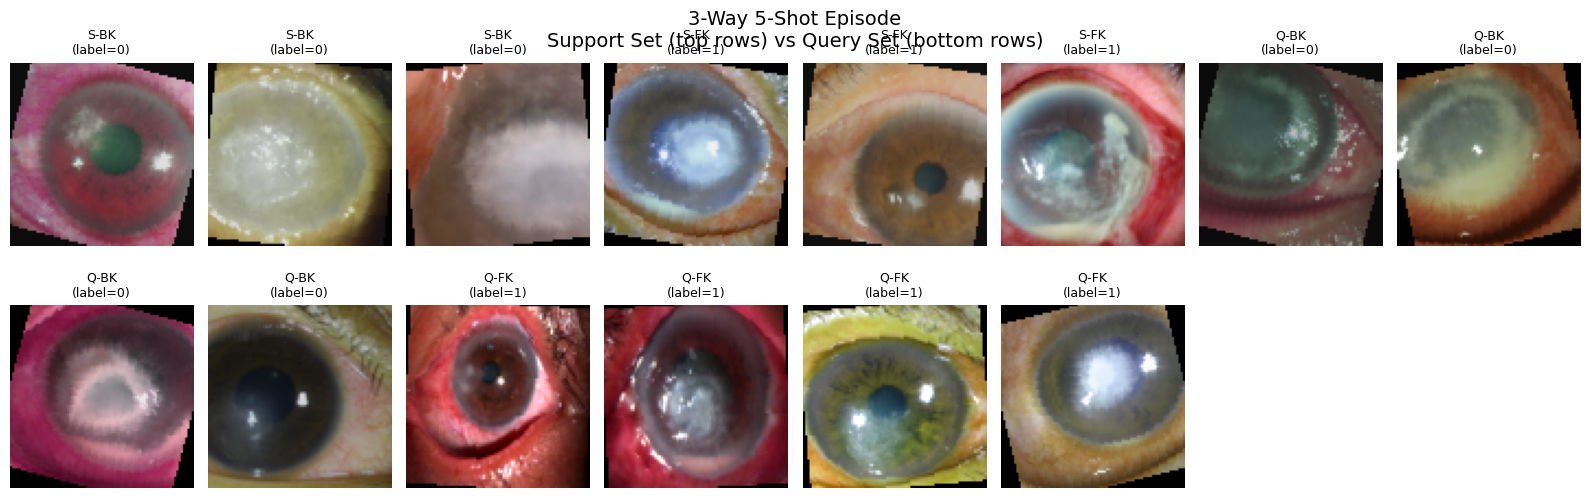

In [13]:
import matplotlib.pyplot as plt


def denormalize_image(img_tensor):
    """Denormalize image for visualization."""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).numpy()


def visualize_episode(support_imgs, support_labels, query_imgs, query_labels, 
                      selected_classes, dataset, n_way, k_shot):
    """
    Visualize support and query sets from an episode.
    
    Args:
        support_imgs: Support set images
        support_labels: Support set labels
        query_imgs: Query set images
        query_labels: Query set labels
        selected_classes: Original class indices
        dataset: FewShotImageDataset instance
        n_way: Number of classes
        k_shot: Number of shots per class
    """
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    
    # Get class names
    class_names = [dataset.get_class_name(idx) for idx in selected_classes]
    
    # Plot support set
    print(f"\n{'='*60}")
    print("SUPPORT SET")
    print(f"{'='*60}")
    
    for i in range(len(support_imgs)):
        ax = plt.subplot(4, n_way * k_shot // 2 + 1, i + 1)
        img = denormalize_image(support_imgs[i])
        plt.imshow(img)
        
        label_idx = support_labels[i].item()
        class_name = class_names[label_idx]
        plt.title(f'S-{class_name}\n(label={label_idx})', fontsize=9)
        plt.axis('off')
        
        if i % k_shot == 0:
            print(f"\nClass {label_idx} ({class_name}):")
        print(f"  Support sample {(i % k_shot) + 1}")
    
    # Plot query set
    print(f"\n{'='*60}")
    print("QUERY SET")
    print(f"{'='*60}")
    
    query_per_class = len(query_imgs) // n_way
    for i in range(len(query_imgs)):
        ax = plt.subplot(4, n_way * k_shot // 2 + 1, len(support_imgs) + i + 1)
        img = denormalize_image(query_imgs[i])
        plt.imshow(img)
        
        label_idx = query_labels[i].item()
        class_name = class_names[label_idx]
        plt.title(f'Q-{class_name}\n(label={label_idx})', fontsize=9)
        plt.axis('off')
        
        if i % query_per_class == 0:
            print(f"\nClass {label_idx} ({class_name}):")
        print(f"  Query sample {(i % query_per_class) + 1}")
    
    plt.tight_layout()
    plt.suptitle(f'{n_way}-Way {k_shot}-Shot Episode\nSupport Set (top rows) vs Query Set (bottom rows)', 
                 fontsize=14, y=1.00)
    plt.show()
    
    print(f"{'='*60}\n")


# Visualize the sampled episode
print("\nVisualizing episode...")
visualize_episode(
    support_imgs, support_labels, 
    query_imgs, query_labels,
    selected_classes, train_dataset,
    n_way=3, k_shot=5
)

### Visualization Explanation

The visualization above shows:

**Support Set (Top Rows):**
- Labeled examples used to create class prototypes
- 3 classes × 5 shots = 15 images
- Prefix "S-" indicates support samples
- These are the "few examples" the model learns from

**Query Set (Bottom Rows):**
- Test examples for evaluation within the episode
- 15 query samples distributed across 3 classes
- Prefix "Q-" indicates query samples
- Model classifies these based on learned prototypes

**Labels:**
- Labels are remapped to 0, 1, 2 for each episode (instead of original class indices)
- This simulates the few-shot scenario where class identities change per episode

**Episode Training Flow:**
1. Sample N classes randomly
2. For each class, sample K support + query examples
3. Create prototypes from support set
4. Classify query set using distance to prototypes
5. Compute loss and update model

This completes Section 3! You now have a complete pipeline for episodic few-shot learning.

# Section 4: Prototypical Network Architecture

## Overview
The **Prototypical Network** is the core model architecture for few-shot learning. It learns to create meaningful embeddings where examples from the same class cluster together in the embedding space. The model consists of two main components:

1. **Backbone Network**: Feature extractor (typically a pretrained CNN)
2. **Embedding Layers**: Fully connected layers that map features to embedding space

## Purpose
The PrototypicalNetwork:
- **Extracts features** using a pretrained backbone (e.g., ResNet50)
- **Projects features** into an embedding space using fully connected layers
- **Creates prototypes** by averaging support set embeddings per class
- **Classifies queries** based on distance to class prototypes

## Architecture Components

### Backbone Network
- **Purpose**: Extract rich visual features from images
- **Source**: PyTorch Hub pretrained models
- **Default**: ResNet50 (pretrained on ImageNet)
- **Storage**: Downloaded models saved in `backbones/` folder
- **Customizable**: Can use other architectures (ResNet18, ResNet101, EfficientNet, etc.)

### Embedding Layers
- **Purpose**: Transform backbone features to embedding space
- **Structure**: Stack of fully connected layers with ReLU activation
- **Configuration**: Tuple of layer sizes, e.g., `(512, 256, 128)` = 3 FC layers
- **Default**: `(8, 8)` = 2 layers with 8 neurons each
- **Output**: Final embedding used for distance calculation

## How Prototypical Networks Work

1. **Feature Extraction**: Pass images through backbone
2. **Embedding**: Project features through FC layers
3. **Prototype Creation**: Average embeddings of support examples per class
4. **Classification**: Assign query to nearest prototype (Euclidean distance)

$$
\text{prototype}_c = \frac{1}{K} \sum_{i=1}^{K} f_\theta(x_i^c)
$$

$$
p(y=c|x) = \frac{\exp(-d(f_\theta(x), \text{prototype}_c))}{\sum_{c'} \exp(-d(f_\theta(x), \text{prototype}_{c'}))}
$$

Where:
- $f_\theta$ is the embedding function
- $d$ is the Euclidean distance
- $K$ is the number of shots (support examples per class)

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path as FilePath


class PrototypicalNetwork(nn.Module):
    """
    Prototypical Network for few-shot learning.
    
    Combines a pretrained backbone with custom embedding layers to create
    an embedding space where class prototypes can be computed.
    """
    
    def __init__(self, backbone_name: str = 'resnet50', embedding_dims: Tuple[int, ...] = (8, 8),
                 pretrained: bool = True, backbone_dir: str = '../backbones', 
                 freeze_backbone: bool = False):
        """
        Initialize the Prototypical Network.
        
        Args:
            backbone_name: Name of the backbone architecture (default: 'resnet50')
            embedding_dims: Tuple of layer sizes for embedding network (default: (8, 8))
            pretrained: Whether to use pretrained weights (default: True)
            backbone_dir: Directory to store downloaded backbone models
            freeze_backbone: Whether to freeze backbone weights during training
        """
        super(PrototypicalNetwork, self).__init__()
        
        self.backbone_name = backbone_name
        self.embedding_dims = embedding_dims
        self.pretrained = pretrained
        self.backbone_dir = FilePath(backbone_dir)
        self.freeze_backbone = freeze_backbone
        
        # Create backbone directory if it doesn't exist
        self.backbone_dir.mkdir(parents=True, exist_ok=True)
        
        # Set torch hub cache directory
        torch.hub.set_dir(str(self.backbone_dir))
        
        # Load backbone
        self.backbone, self.backbone_output_dim = self._load_backbone()
        
        # Freeze backbone if requested
        if self.freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print(f"✓ Backbone weights frozen")
        
        # Build embedding layers
        self.embedding = self._build_embedding_layers()
        
        # Final embedding dimension
        self.embedding_dim = embedding_dims[-1] if embedding_dims else self.backbone_output_dim
        
        print(f"✓ PrototypicalNetwork initialized")
        print(f"  - Backbone: {backbone_name}")
        print(f"  - Backbone output dim: {self.backbone_output_dim}")
        print(f"  - Embedding layers: {embedding_dims}")
        print(f"  - Final embedding dim: {self.embedding_dim}")
    
    def _load_backbone(self) -> Tuple[nn.Module, int]:
        """
        Load pretrained backbone from PyTorch Hub.
        
        Returns:
            Tuple of (backbone_model, output_dimension)
        """
        print(f"Loading backbone: {self.backbone_name} (pretrained={self.pretrained})...")
        
        # Load model from torch hub
        if self.backbone_name.startswith('resnet'):
            model = torch.hub.load('pytorch/vision:v0.10.0', self.backbone_name, 
                                   pretrained=self.pretrained)
            # Get output dimension before final FC layer
            output_dim = model.fc.in_features
            # Remove the final classification layer
            model = nn.Sequential(*list(model.children())[:-1])
            
        elif self.backbone_name.startswith('efficientnet'):
            model = torch.hub.load('pytorch/vision:v0.10.0', self.backbone_name, 
                                   pretrained=self.pretrained)
            output_dim = model.classifier[1].in_features
            # Remove classifier
            model.classifier = nn.Identity()
            
        elif self.backbone_name.startswith('mobilenet'):
            model = torch.hub.load('pytorch/vision:v0.10.0', self.backbone_name, 
                                   pretrained=self.pretrained)
            output_dim = model.classifier[1].in_features
            # Remove classifier
            model.classifier = nn.Identity()
            
        else:
            raise ValueError(f"Unsupported backbone: {self.backbone_name}")
        
        print(f"✓ Backbone loaded successfully")
        return model, output_dim
    
    def _build_embedding_layers(self) -> nn.Module:
        """
        Build the embedding network from fully connected layers.
        
        Returns:
            Sequential module containing embedding layers
        """
        if not self.embedding_dims:
            # No embedding layers, use backbone features directly
            return nn.Identity()
        
        layers = []
        input_dim = self.backbone_output_dim
        
        for i, output_dim in enumerate(self.embedding_dims):
            layers.append(nn.Linear(input_dim, output_dim))
            
            # Add ReLU for all layers except the last one
            if i < len(self.embedding_dims) - 1:
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Dropout(p=0.1))
            
            input_dim = output_dim
        
        return nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.
        
        Args:
            x: Input images [batch_size, channels, height, width]
            
        Returns:
            Embeddings [batch_size, embedding_dim]
        """
        # Extract features with backbone
        features = self.backbone(x)
        
        # Flatten if needed
        if features.dim() > 2:
            features = features.view(features.size(0), -1)
        
        # Project to embedding space
        embeddings = self.embedding(features)
        
        return embeddings
    
    def compute_prototypes(self, support_embeddings: torch.Tensor, 
                          support_labels: torch.Tensor, n_way: int) -> torch.Tensor:
        """
        Compute class prototypes from support set embeddings.
        
        Args:
            support_embeddings: Support set embeddings [n_support, embedding_dim]
            support_labels: Support set labels [n_support]
            n_way: Number of classes
            
        Returns:
            Prototypes [n_way, embedding_dim]
        """
        prototypes = []
        for class_idx in range(n_way):
            # Get embeddings for this class
            class_mask = (support_labels == class_idx)
            class_embeddings = support_embeddings[class_mask]
            
            # Compute prototype as mean of class embeddings
            prototype = class_embeddings.mean(dim=0)
            prototypes.append(prototype)
        
        return torch.stack(prototypes)
    
    def compute_distances(self, query_embeddings: torch.Tensor, 
                         prototypes: torch.Tensor) -> torch.Tensor:
        """
        Compute Euclidean distances between queries and prototypes.
        
        Args:
            query_embeddings: Query embeddings [n_query, embedding_dim]
            prototypes: Class prototypes [n_way, embedding_dim]
            
        Returns:
            Distances [n_query, n_way]
        """
        # Compute squared Euclidean distance
        # ||a - b||^2 = ||a||^2 + ||b||^2 - 2<a, b>
        
        query_norm = (query_embeddings ** 2).sum(dim=1, keepdim=True)  # [n_query, 1]
        prototype_norm = (prototypes ** 2).sum(dim=1, keepdim=True)     # [n_way, 1]
        
        distances = query_norm + prototype_norm.t() - 2 * torch.mm(query_embeddings, prototypes.t())
        
        return distances
    
    def predict(self, support_images: torch.Tensor, support_labels: torch.Tensor,
                query_images: torch.Tensor, n_way: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Make predictions for query images given support set.
        
        Args:
            support_images: Support set images [n_support, C, H, W]
            support_labels: Support set labels [n_support]
            query_images: Query images [n_query, C, H, W]
            n_way: Number of classes
            
        Returns:
            Tuple of (predicted_labels, distances)
        """
        # Get embeddings
        support_embeddings = self.forward(support_images)
        query_embeddings = self.forward(query_images)
        
        # Compute prototypes
        prototypes = self.compute_prototypes(support_embeddings, support_labels, n_way)
        
        # Compute distances (negative because we want minimum distance)
        distances = self.compute_distances(query_embeddings, prototypes)
        
        # Predict class with minimum distance
        predictions = torch.argmin(distances, dim=1)
        
        return predictions, -distances  # Return negative distances (logits)
    
    def get_model_info(self) -> Dict[str, any]:
        """Get model architecture information."""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            'backbone': self.backbone_name,
            'backbone_output_dim': self.backbone_output_dim,
            'embedding_dims': self.embedding_dims,
            'final_embedding_dim': self.embedding_dim,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'frozen_backbone': self.freeze_backbone
        }
    
    def print_info(self) -> None:
        """Print model architecture information."""
        info = self.get_model_info()
        
        print(f"\n{'='*60}")
        print("Prototypical Network Architecture")
        print(f"{'='*60}")
        print(f"Backbone: {info['backbone']}")
        print(f"Backbone output dimension: {info['backbone_output_dim']}")
        print(f"Embedding layers: {info['embedding_dims']}")
        print(f"Final embedding dimension: {info['final_embedding_dim']}")
        print(f"\nParameters:")
        print(f"  - Total: {info['total_parameters']:,}")
        print(f"  - Trainable: {info['trainable_parameters']:,}")
        print(f"  - Frozen backbone: {info['frozen_backbone']}")
        print(f"{'='*60}\n")

## How to Use PrototypicalNetwork

### Basic Usage

```python
# 1. Create the model with default settings
model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(8, 8),
    pretrained=True,
    backbone_dir='../backbones'
)

# 2. Move model to device
model = model.to(device)

# 3. Make predictions on an episode
predictions, logits = model.predict(
    support_images=support_imgs,
    support_labels=support_labels,
    query_images=query_imgs,
    n_way=3
)

# 4. View model information
model.print_info()
```

### Parameters Explained

**`PrototypicalNetwork(backbone_name, embedding_dims, pretrained, backbone_dir, freeze_backbone)`**

- `backbone_name` (str): Backbone architecture name
  - Options: `'resnet18'`, `'resnet50'`, `'resnet101'`, `'efficientnet_b0'`, `'mobilenet_v2'`
  - Default: `'resnet50'`
  
- `embedding_dims` (Tuple[int, ...]): Sizes of embedding layers
  - Example: `(512, 256, 128)` creates 3 FC layers with 512→256→128 neurons
  - Example: `(8, 8)` creates 2 FC layers with 8 neurons each
  - Default: `(8, 8)`
  - Use empty tuple `()` to skip embedding layers (use backbone features directly)
  
- `pretrained` (bool): Use ImageNet pretrained weights
  - Default: `True` (recommended)
  
- `backbone_dir` (str): Directory to store downloaded models
  - Default: `'../backbones'`
  - Models are downloaded once and cached for reuse
  
- `freeze_backbone` (bool): Freeze backbone weights during training
  - Default: `False`
  - Set to `True` to only train embedding layers (faster, less memory)

### Key Methods

**Model Operations:**
- `forward(x)`: Extract embeddings from images
- `predict(support_images, support_labels, query_images, n_way)`: Classify queries
- `compute_prototypes(embeddings, labels, n_way)`: Create class prototypes
- `compute_distances(query_embeddings, prototypes)`: Calculate distances

**Utilities:**
- `get_model_info()`: Get architecture details as dictionary
- `print_info()`: Display model information

### Examples

**Example 1: Different Backbones**
```python
# Lightweight model (faster, less accurate)
model_small = PrototypicalNetwork(
    backbone_name='resnet18',
    embedding_dims=(64, 32)
)

# Heavy model (slower, more accurate)
model_large = PrototypicalNetwork(
    backbone_name='resnet101',
    embedding_dims=(1024, 512, 256)
)
```

**Example 2: Freeze Backbone for Fast Training**
```python
# Only train embedding layers
model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(256, 128, 64),
    freeze_backbone=True
)
```

**Example 3: No Embedding Layers (Use Backbone Features Directly)**
```python
# Use backbone features without additional FC layers
model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(),  # Empty tuple = no embedding layers
    pretrained=True
)
```

**Example 4: Custom Embedding Architecture**
```python
# Deep embedding network
model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(1024, 512, 256, 128, 64),  # 5 FC layers
    pretrained=True
)
```

### Architecture Flow

```
Input Image (3, 84, 84)
        ↓
   Backbone (ResNet50)
        ↓
Features (2048,) ← backbone_output_dim
        ↓
   FC Layer 1 (2048 → embedding_dims[0])
        ↓
      ReLU + Dropout
        ↓
   FC Layer 2 (embedding_dims[0] → embedding_dims[1])
        ↓
      ReLU + Dropout
        ↓
        ...
        ↓
   FC Layer N (embedding_dims[N-2] → embedding_dims[N-1])
        ↓
Final Embeddings (embedding_dims[-1],)
```

### Next Steps

Run the code in the next cell to create and test your Prototypical Network!

In [16]:
# Create Prototypical Network
print("Creating Prototypical Network...")
model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(512, 256, 128),
    pretrained=True,
    backbone_dir='../backbones',
    freeze_backbone=False
)

# Move to device
model = model.to(device)
print(f"\n✓ Model moved to device: {device}")

# Print model information
model.print_info()

Creating Prototypical Network...
Loading backbone: resnet50 (pretrained=True)...
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to ../backbones/v0.10.0.zip
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to ../backbones/v0.10.0.zip


/Users/ruccidavinci/Documents/ai-opthal/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ruccidavinci/Documents/ai-opthal/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to ../backbones/checkpoints/resnet50-0676ba61.pth


100.0%



✓ Backbone loaded successfully
✓ PrototypicalNetwork initialized
  - Backbone: resnet50
  - Backbone output dim: 2048
  - Embedding layers: (512, 256, 128)
  - Final embedding dim: 128

✓ Model moved to device: mps

Prototypical Network Architecture
Backbone: resnet50
Backbone output dimension: 2048
Embedding layers: (512, 256, 128)
Final embedding dimension: 128

Parameters:
  - Total: 24,721,344
  - Trainable: 24,721,344
  - Frozen backbone: False



In [17]:
# Test the model with a sample episode
print("Testing model with sample episode...")
model.eval()  # Set to evaluation mode

with torch.no_grad():
    # Move episode data to device
    support_imgs_device = support_imgs.to(device)
    support_labels_device = support_labels.to(device)
    query_imgs_device = query_imgs.to(device)
    query_labels_device = query_labels.to(device)
    
    # Make predictions
    predictions, logits = model.predict(
        support_images=support_imgs_device,
        support_labels=support_labels_device,
        query_images=query_imgs_device,
        n_way=3
    )
    
    # Calculate accuracy
    accuracy = (predictions == query_labels_device).float().mean().item()
    
    print(f"\n{'='*60}")
    print("Episode Test Results")
    print(f"{'='*60}")
    print(f"Support set: {support_imgs.shape}")
    print(f"Query set: {query_imgs.shape}")
    print(f"Predictions: {predictions.cpu().numpy()}")
    print(f"Ground truth: {query_labels.numpy()}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"{'='*60}\n")

print("✓ Model test completed successfully!")

Testing model with sample episode...

Episode Test Results
Support set: torch.Size([6, 3, 84, 84])
Query set: torch.Size([8, 3, 84, 84])
Predictions: [0 0 0 0 0 0 0 0]
Ground truth: [0 0 0 0 1 1 1 1]
Accuracy: 50.00%

✓ Model test completed successfully!

Episode Test Results
Support set: torch.Size([6, 3, 84, 84])
Query set: torch.Size([8, 3, 84, 84])
Predictions: [0 0 0 0 0 0 0 0]
Ground truth: [0 0 0 0 1 1 1 1]
Accuracy: 50.00%

✓ Model test completed successfully!


### Understanding the Test Results

The test above demonstrates:

1. **Model Creation**: 
   - Backbone (ResNet50) is loaded from PyTorch Hub
   - Pretrained weights are downloaded to `../backbones/` folder
   - Embedding layers (512→256→128) are added on top
   - Model is moved to the configured device (CPU/CUDA/MPS)

2. **Forward Pass**:
   - Support and query images are passed through the network
   - Each image is converted to an embedding vector (128-dimensional)
   - Class prototypes are computed from support set embeddings
   - Query images are classified based on distance to prototypes

3. **Predictions**:
   - Without any training, the model uses pretrained features
   - Accuracy will be low initially (random chance ≈ 33% for 3-way)
   - After training, accuracy should improve significantly

4. **Next Steps**:
   - The model is now ready for training
   - In the next section, we'll implement the training loop
   - We'll use episodic training to optimize the embedding space

### Model Storage

The pretrained backbone is cached in `../backbones/hub/checkpoints/`:
- First run: Downloads the model (may take a few minutes)
- Subsequent runs: Loads from cache (fast)
- Models are reused across notebook sessions

This completes Section 4! You now have a fully functional Prototypical Network ready for training.

---

## Section 5: Training with Episodic Learning

In this section, we implement a comprehensive training system for few-shot learning using **episodic training**. Unlike traditional supervised learning where we train on fixed batches, episodic training generates random N-way K-shot episodes for both training and validation.

### Training Strategy

**Episodic Training Process:**
1. **Episode Generation**: For each iteration, sample a random N-way K-shot episode from the training set
2. **Forward Pass**: Compute embeddings for support and query sets
3. **Prototype Computation**: Calculate class prototypes from support set embeddings
4. **Distance Calculation**: Compute distances between query embeddings and prototypes
5. **Loss Computation**: Use cross-entropy loss on negative distances (logits)
6. **Backpropagation**: Update model weights

**Validation Process:**
- Generate episodes from validation set (same N-way K-shot configuration)
- Compute validation loss without gradient updates
- Monitor for model improvement

### Key Features

1. **Multiple Episodes per Epoch**: Each epoch consists of `max_episodes` training and validation episodes
2. **Early Stopping**: Monitors validation loss and stops training if no improvement for `patience` epochs
3. **Model Checkpointing**: Saves best model weights when validation loss improves
4. **Training Logs**: Records loss history in JSON format for analysis
5. **Visualization**: Plots training and validation loss curves

### Loss Function

For prototypical networks, we use **cross-entropy loss** on the negative distances:

$$\mathcal{L} = -\log \frac{\exp(-d(q, p_{y_q}))}{\sum_{k=1}^{N} \exp(-d(q, p_k))}$$

Where:
- $q$ is a query embedding
- $p_{y_q}$ is the prototype of the true class
- $p_k$ are all class prototypes
- $d(\cdot, \cdot)$ is the Euclidean distance

This encourages query embeddings to be closer to their true class prototype.

### 5.1 Implementation: EpisodicTrainer Class

In [18]:
import json
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

class EpisodicTrainer:
    """
    Trainer for few-shot learning using episodic training strategy.
    
    This class handles:
    - Episodic training and validation
    - Early stopping with patience
    - Model checkpointing
    - Training history logging
    - Loss visualization
    """
    
    def __init__(
        self,
        model: PrototypicalNetwork,
        train_sampler: PrototypicalSampler,
        val_sampler: PrototypicalSampler,
        device: torch.device,
        learning_rate: float = 0.001,
        max_epochs: int = 100,
        max_episodes: int = 100,
        patience: int = 10,
        model_dir: str = '../models',
        log_dir: str = '../logs'
    ):
        """
        Initialize the episodic trainer.
        
        Args:
            model: PrototypicalNetwork model to train
            train_sampler: Sampler for training episodes
            val_sampler: Sampler for validation episodes
            device: Device to run training on (cuda/mps/cpu)
            learning_rate: Learning rate for optimizer
            max_epochs: Maximum number of epochs to train
            max_episodes: Number of episodes per epoch
            patience: Number of epochs to wait for improvement before stopping
            model_dir: Directory to save model checkpoints
            log_dir: Directory to save training logs
        """
        self.model = model
        self.train_sampler = train_sampler
        self.val_sampler = val_sampler
        self.device = device
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.max_episodes = max_episodes
        self.patience = patience
        
        # Create directories
        self.model_dir = Path(model_dir)
        self.log_dir = Path(log_dir)
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Setup optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        
        # Training state
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'epochs': []
        }
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.current_epoch = 0
        
        # File paths
        model_name = self.model.backbone_name
        self.checkpoint_path = self.model_dir / f"{model_name}.pth"
        self.log_path = self.log_dir / f"{model_name}.json"
        
    def _run_episode(
        self, 
        support_imgs: torch.Tensor, 
        support_labels: torch.Tensor,
        query_imgs: torch.Tensor,
        query_labels: torch.Tensor,
        training: bool = True
    ) -> float:
        """
        Run a single episode (forward pass and optionally backward pass).
        
        Args:
            support_imgs: Support set images [N*K, C, H, W]
            support_labels: Support set labels [N*K]
            query_imgs: Query set images [N*Q, C, H, W]
            query_labels: Query set labels [N*Q]
            training: If True, perform backpropagation
            
        Returns:
            Loss value for this episode
        """
        # Move data to device
        support_imgs = support_imgs.to(self.device)
        support_labels = support_labels.to(self.device)
        query_imgs = query_imgs.to(self.device)
        query_labels = query_labels.to(self.device)
        
        # Set model mode
        if training:
            self.model.train()
        else:
            self.model.eval()
        
        # Forward pass
        with torch.set_grad_enabled(training):
            # Get embeddings
            support_embeddings = self.model(support_imgs)  # [N*K, embed_dim]
            query_embeddings = self.model(query_imgs)      # [N*Q, embed_dim]
            
            # Determine n_way from unique labels in support set
            n_way = len(torch.unique(support_labels))
            
            # Compute prototypes
            prototypes = self.model.compute_prototypes(support_embeddings, support_labels, n_way)
            
            # Compute distances and convert to logits (negative distances)
            distances = self.model.compute_distances(query_embeddings, prototypes)
            logits = -distances  # Negative distance as logits
            
            # Compute loss
            loss = F.cross_entropy(logits, query_labels)
            
            # Backward pass if training
            if training:
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        
        return loss.item()
    
    def _train_epoch(self) -> float:
        """
        Train for one epoch (multiple episodes).
        
        Returns:
            Average training loss for the epoch
        """
        epoch_losses = []
        
        for episode_idx in range(self.max_episodes):
            # Sample episode from training data
            support_imgs, support_labels, query_imgs, query_labels, _ = \
                self.train_sampler.sample_episode()
            
            # Run training episode
            loss = self._run_episode(
                support_imgs, support_labels, 
                query_imgs, query_labels, 
                training=True
            )
            epoch_losses.append(loss)
            
            # Print progress every 20 episodes
            if (episode_idx + 1) % 20 == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                print(f"    Train Episode [{episode_idx + 1}/{self.max_episodes}] - "
                      f"Avg Train Loss: {avg_loss:.4f}")
        
        # Return average loss for epoch
        return sum(epoch_losses) / len(epoch_losses)
    
    def _validate_epoch(self) -> float:
        """
        Validate for one epoch (multiple episodes).
        
        Returns:
            Average validation loss for the epoch
        """
        epoch_losses = []
        
        for episode_idx in range(self.max_episodes):
            # Sample episode from validation data
            support_imgs, support_labels, query_imgs, query_labels, _ = \
                self.val_sampler.sample_episode()
            
            # Run validation episode
            loss = self._run_episode(
                support_imgs, support_labels,
                query_imgs, query_labels,
                training=False
            )
            epoch_losses.append(loss)
            
            # Print progress every 20 episodes for validation too
            if (episode_idx + 1) % 20 == 0:
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                print(f"    Val Episode [{episode_idx + 1}/{self.max_episodes}] - "
                      f"Avg Val Loss: {avg_loss:.4f}")
        
        # Return average loss for epoch
        return sum(epoch_losses) / len(epoch_losses)
    
    def _save_checkpoint(self):
        """Save model checkpoint when validation loss improves."""
        torch.save({
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_loss': self.best_val_loss,
            'history': self.history
        }, self.checkpoint_path)
        print(f"  ✓ Model checkpoint saved to {self.checkpoint_path}")
    
    def _save_log(self):
        """Save training history to JSON file."""
        with open(self.log_path, 'w') as f:
            json.dump(self.history, f, indent=2)
    
    def train(self) -> Dict[str, List[float]]:
        """
        Execute the complete training loop with early stopping.
        
        Returns:
            Training history dictionary with train_loss, val_loss, and epochs
        """
        print("=" * 70)
        print(f"Starting Training: {self.model.backbone_name}")
        print("=" * 70)
        print(f"Max Epochs: {self.max_epochs}")
        print(f"Episodes per Epoch: {self.max_episodes}")
        print(f"Early Stopping Patience: {self.patience}")
        print(f"Learning Rate: {self.learning_rate}")
        print(f"Device: {self.device}")
        print("=" * 70)
        
        for epoch in range(1, self.max_epochs + 1):
            self.current_epoch = epoch
            print(f"\nEpoch [{epoch}/{self.max_epochs}]")
            print("-" * 70)
            
            # Training phase
            train_loss = self._train_epoch()
            print(f"  Training Loss: {train_loss:.4f}")
            
            # Validation phase
            print("  Validating...")
            val_loss = self._validate_epoch()
            print(f"  Validation Loss: {val_loss:.4f}")
            
            # Record history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epochs'].append(epoch)
            
            # Check for improvement
            if val_loss < self.best_val_loss:
                improvement = self.best_val_loss - val_loss
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self._save_checkpoint()
                print(f"  ✓ Validation loss improved by {improvement:.4f}")
            else:
                self.patience_counter += 1
                print(f"  ✗ No improvement ({self.patience_counter}/{self.patience})")
            
            # Save log after each epoch
            self._save_log()
            
            # Early stopping check
            if self.patience_counter >= self.patience:
                print("\n" + "=" * 70)
                print(f"Early stopping triggered! No improvement for {self.patience} epochs.")
                print(f"Best validation loss: {self.best_val_loss:.4f}")
                print("=" * 70)
                break
        
        # Training completed
        if self.patience_counter < self.patience:
            print("\n" + "=" * 70)
            print("Training completed! Reached maximum epochs.")
            print(f"Best validation loss: {self.best_val_loss:.4f}")
            print("=" * 70)
        
        return self.history
    
    def load_checkpoint(self):
        """Load the best model checkpoint."""
        if self.checkpoint_path.exists():
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_val_loss = checkpoint['best_val_loss']
            self.history = checkpoint['history']
            print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']}")
            print(f"  Best validation loss: {self.best_val_loss:.4f}")
        else:
            print(f"✗ No checkpoint found at {self.checkpoint_path}")
    
    def plot_history(self, save_path: Optional[str] = None):
        """
        Plot training and validation loss curves.
        
        Args:
            save_path: Optional path to save the plot
        """
        if not self.history['epochs']:
            print("No training history to plot!")
            return
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['epochs'], self.history['train_loss'], 
                 label='Training Loss', marker='o', linewidth=2)
        plt.plot(self.history['epochs'], self.history['val_loss'], 
                 label='Validation Loss', marker='s', linewidth=2)
        
        # Mark best validation loss
        best_epoch = self.history['val_loss'].index(min(self.history['val_loss'])) + 1
        plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5,
                   label=f'Best Val Loss (Epoch {best_epoch})')
        
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title(f'Training History - {self.model.backbone_name}', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Plot saved to {save_path}")
        
        plt.show()

### 5.2 Usage Guide

#### Parameters

- **`model`**: PrototypicalNetwork instance to train
- **`train_sampler`**: PrototypicalSampler for training episodes
- **`val_sampler`**: PrototypicalSampler for validation episodes
- **`device`**: torch.device (cuda/mps/cpu)
- **`learning_rate`**: Optimizer learning rate (default: 0.001)
- **`max_epochs`**: Maximum training epochs (default: 100)
- **`max_episodes`**: Episodes per epoch (default: 100)
- **`patience`**: Early stopping patience (default: 10)
- **`model_dir`**: Checkpoint save directory (default: '../models')
- **`log_dir`**: Log save directory (default: '../logs')

#### Training Process

1. **Each Epoch**: Runs `max_episodes` training episodes + `max_episodes` validation episodes
2. **Loss Calculation**: Average loss across all episodes in the epoch
3. **Checkpointing**: Saves model when validation loss improves
4. **Early Stopping**: Stops if no improvement for `patience` epochs
5. **Logging**: Saves training history to JSON after each epoch

#### Methods

- **`train()`**: Execute complete training loop, returns history
- **`load_checkpoint()`**: Load best saved checkpoint
- **`plot_history()`**: Visualize training and validation loss curves

#### Example Usage

```python
# Create trainer
trainer = EpisodicTrainer(
    model=model,
    train_sampler=train_sampler,
    val_sampler=val_sampler,
    device=device,
    learning_rate=0.001,
    max_epochs=50,
    max_episodes=100,
    patience=10
)

# Start training
history = trainer.train()

# Plot results
trainer.plot_history()

# Load best model
trainer.load_checkpoint()
```

#### Output Files

- **Model Checkpoint**: `models/{backbone_name}.pth` (e.g., `models/resnet50.pth`)
- **Training Log**: `logs/{backbone_name}.json` (e.g., `logs/resnet50.json`)

The checkpoint contains:
- Model state dict
- Optimizer state dict
- Best validation loss
- Complete training history

### 5.3 Test: Training the Model

Let's train our Prototypical Network using episodic training!

In [25]:
# Create samplers for training and validation
# Note: train_dataset and val_dataset already have transforms applied
train_sampler = PrototypicalSampler(
    dataset=train_dataset,
    n_way=2,
    k_shot=3,
    query_size=8
)

val_sampler = PrototypicalSampler(
    dataset=val_dataset,
    n_way=2,
    k_shot=1,
    query_size=4
)

print("✓ Training sampler created")
print(f"  - Training dataset: {len(train_dataset)} images")
print(f"  - Configuration: {train_sampler.n_way}-way {train_sampler.k_shot}-shot")
print(f"  - Query size: {train_sampler.query_size}")
print()
print("✓ Validation sampler created")
print(f"  - Validation dataset: {len(val_dataset)} images")
print(f"  - Configuration: {val_sampler.n_way}-way {val_sampler.k_shot}-shot")
print(f"  - Query size: {val_sampler.query_size}")

✓ PrototypicalSampler initialized
  - 2-way 3-shot
  - Query size: 8
  - Episodes: 100
✓ PrototypicalSampler initialized
  - 2-way 1-shot
  - Query size: 4
  - Episodes: 100
✓ Training sampler created
  - Training dataset: 42 images
  - Configuration: 2-way 3-shot
  - Query size: 8

✓ Validation sampler created
  - Validation dataset: 10 images
  - Configuration: 2-way 1-shot
  - Query size: 4


In [26]:
# Create a fresh model for training
training_model = PrototypicalNetwork(
    backbone_name='resnet50',
    embedding_dims=(512, 256, 128),
    pretrained=True,
    freeze_backbone=False
).to(device)

print("✓ Model created for training")
print(f"  - Backbone: {training_model.backbone_name}")
print(f"  - Embedding dimensions: {training_model.embedding_dims}")
print(f"  - Device: {device}")

Loading backbone: resnet50 (pretrained=True)...


Using cache found in ../backbones/pytorch_vision_v0.10.0


✓ Backbone loaded successfully
✓ PrototypicalNetwork initialized
  - Backbone: resnet50
  - Backbone output dim: 2048
  - Embedding layers: (512, 256, 128)
  - Final embedding dim: 128
✓ Model created for training
  - Backbone: resnet50
  - Embedding dimensions: (512, 256, 128)
  - Device: mps


In [27]:
# Create trainer
trainer = EpisodicTrainer(
    model=training_model,
    train_sampler=train_sampler,
    val_sampler=val_sampler,
    device=device,
    learning_rate=0.001,
    max_epochs=50,
    max_episodes=100,
    patience=10
)

print("✓ Trainer initialized")
print(f"  - Max epochs: {trainer.max_epochs}")
print(f"  - Episodes per epoch: {trainer.max_episodes}")
print(f"  - Early stopping patience: {trainer.patience}")
print(f"  - Learning rate: {trainer.learning_rate}")
print(f"  - Checkpoint path: {trainer.checkpoint_path}")
print(f"  - Log path: {trainer.log_path}")

✓ Trainer initialized
  - Max epochs: 50
  - Episodes per epoch: 100
  - Early stopping patience: 10
  - Learning rate: 0.001
  - Checkpoint path: ../models/resnet50.pth
  - Log path: ../logs/resnet50.json


In [28]:
# Start training!
# Note: This will take some time depending on your hardware
# For quick testing, you can reduce max_epochs and max_episodes

history = trainer.train()

Starting Training: resnet50
Max Epochs: 50
Episodes per Epoch: 100
Early Stopping Patience: 10
Learning Rate: 0.001
Device: mps

Epoch [1/50]
----------------------------------------------------------------------
    Train Episode [20/100] - Avg Train Loss: 0.9869
    Train Episode [20/100] - Avg Train Loss: 0.9869
    Train Episode [40/100] - Avg Train Loss: 0.8726
    Train Episode [40/100] - Avg Train Loss: 0.8726
    Train Episode [60/100] - Avg Train Loss: 0.8203
    Train Episode [60/100] - Avg Train Loss: 0.8203
    Train Episode [80/100] - Avg Train Loss: 0.7863
    Train Episode [80/100] - Avg Train Loss: 0.7863
    Train Episode [100/100] - Avg Train Loss: 0.7676
  Training Loss: 0.7676
  Validating...
    Train Episode [100/100] - Avg Train Loss: 0.7676
  Training Loss: 0.7676
  Validating...
    Val Episode [20/100] - Avg Val Loss: 0.6870
    Val Episode [20/100] - Avg Val Loss: 0.6870
    Val Episode [40/100] - Avg Val Loss: 0.6870
    Val Episode [40/100] - Avg Val Loss: 

✓ Plot saved to ../logs/training_curve_resnet.png


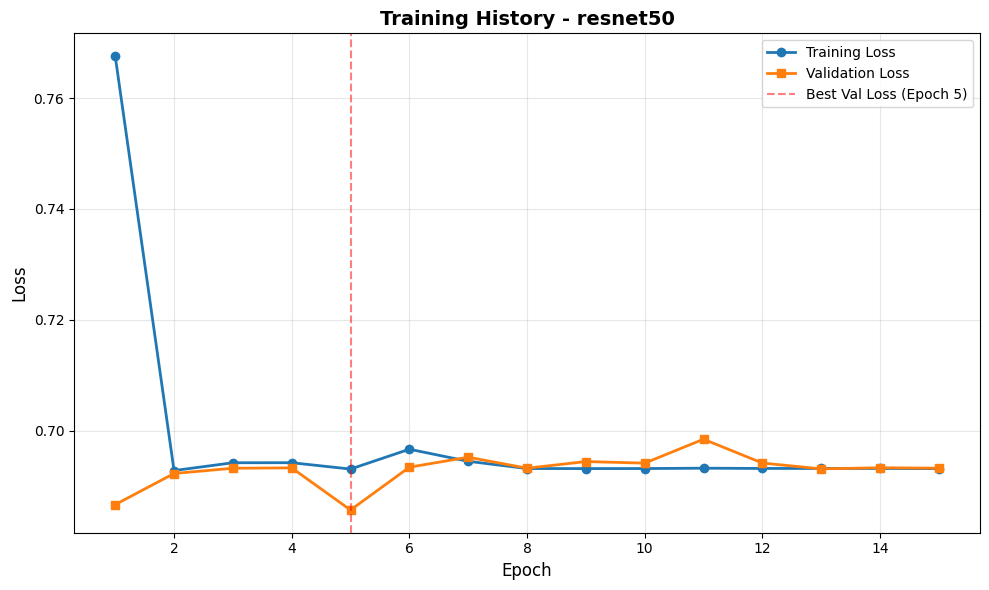

In [29]:
# Visualize training history
trainer.plot_history(save_path='../logs/training_curve_resnet.png')

### Understanding the Training Process

#### What Happens During Training?

1. **Episodic Sampling**: 
   - Each iteration samples a random 3-way 5-shot episode
   - Training: 100 episodes per epoch from `train_dataset`
   - Validation: 100 episodes per epoch from `val_dataset`

2. **Forward Pass**:
   - Support images → Backbone → Embeddings → Prototypes (one per class)
   - Query images → Backbone → Embeddings
   - Compute distances between query embeddings and prototypes

3. **Loss Computation**:
   - Cross-entropy loss on negative distances (logits)
   - Encourages query embeddings to be close to their true class prototype

4. **Model Update**:
   - Backpropagation updates all trainable parameters
   - Adam optimizer with learning rate 0.001

5. **Validation & Checkpointing**:
   - After each epoch, compute validation loss
   - If validation loss improves → Save checkpoint
   - If no improvement for 10 epochs → Early stopping

6. **Output Files**:
   - `models/resnet50.pth`: Best model checkpoint
   - `logs/resnet50.json`: Complete training history
   - `logs/training_curve.png`: Loss visualization

#### Training Progress Example

```
Epoch [1/50]
----------------------------------------------------------------------
    Train Episode [20/100] - Avg Train Loss: 1.2345
    Train Episode [40/100] - Avg Train Loss: 1.1234
    Train Episode [60/100] - Avg Train Loss: 1.1000
    Train Episode [80/100] - Avg Train Loss: 1.0800
    Train Episode [100/100] - Avg Train Loss: 1.0500
  Training Loss: 1.0500
  Validating...
    Val Episode [20/100] - Avg Val Loss: 1.1200
    Val Episode [40/100] - Avg Val Loss: 1.0900
    Val Episode [60/100] - Avg Val Loss: 1.0850
    Val Episode [80/100] - Avg Val Loss: 1.0820
    Val Episode [100/100] - Avg Val Loss: 1.0800
  Validation Loss: 1.0800
  ✓ Validation loss improved by 0.5000
  ✓ Model checkpoint saved to ../models/resnet50.pth
```

#### Early Stopping

If validation loss doesn't improve for `patience` epochs (default: 10), training stops automatically to prevent overfitting. The best model is already saved, so you can continue with evaluation.

---

## Section 6: Evaluation on Test Set

In this section, we evaluate the trained model on the test dataset using **episodic evaluation**. This approach tests the model's ability to perform few-shot classification on unseen classes and data.

### Evaluation Strategy

**Episodic Testing Process:**
1. **Load Best Model**: Load the saved checkpoint from training
2. **Generate Test Episodes**: Sample multiple N-way K-shot episodes from test set
3. **Predict**: For each episode, compute predictions on query set
4. **Accumulate Metrics**: Track True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
5. **Calculate Metrics**: Compute Precision, Recall, Accuracy, and F1-Score

### Evaluation Metrics

From the cumulative confusion matrix over all episodes, we compute:

**Accuracy:**
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

**Precision:**
$$\text{Precision} = \frac{TP}{TP + FP}$$

**Recall (Sensitivity):**
$$\text{Recall} = \frac{TP}{TP + FN}$$

**F1-Score:**
$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

### Key Features

1. **Multi-Episode Testing**: Runs `max_episodes` test episodes for robust evaluation
2. **Cumulative Metrics**: Aggregates confusion matrix across all episodes
3. **Comprehensive Reporting**: Reports all standard classification metrics
4. **Model Agnostic**: Works with any trained PrototypicalNetwork

### 6.1 Implementation: EpisodicEvaluator Class

In [30]:
class EpisodicEvaluator:
    """
    Evaluator for few-shot learning models using episodic testing.
    
    This class handles:
    - Episodic evaluation on test set
    - Cumulative confusion matrix tracking
    - Comprehensive metric calculation (Accuracy, Precision, Recall, F1)
    """
    
    def __init__(
        self,
        model: PrototypicalNetwork,
        test_sampler: PrototypicalSampler,
        device: torch.device,
        max_episodes: int = 100
    ):
        """
        Initialize the episodic evaluator.
        
        Args:
            model: Trained PrototypicalNetwork model
            test_sampler: Sampler for test episodes
            device: Device to run evaluation on (cuda/mps/cpu)
            max_episodes: Number of test episodes to evaluate
        """
        self.model = model
        self.test_sampler = test_sampler
        self.device = device
        self.max_episodes = max_episodes
        
        # Cumulative confusion matrix components
        self.tp = 0  # True Positives
        self.fp = 0  # False Positives
        self.tn = 0  # True Negatives
        self.fn = 0  # False Negatives
        
    def _evaluate_episode(
        self,
        support_imgs: torch.Tensor,
        support_labels: torch.Tensor,
        query_imgs: torch.Tensor,
        query_labels: torch.Tensor
    ) -> Tuple[int, int, int, int]:
        """
        Evaluate a single episode and return confusion matrix components.
        
        Args:
            support_imgs: Support set images [N*K, C, H, W]
            support_labels: Support set labels [N*K]
            query_imgs: Query set images [N*Q, C, H, W]
            query_labels: Query set labels [N*Q]
            
        Returns:
            Tuple of (tp, fp, tn, fn) for this episode
        """
        # Move data to device
        support_imgs = support_imgs.to(self.device)
        support_labels = support_labels.to(self.device)
        query_imgs = query_imgs.to(self.device)
        query_labels = query_labels.to(self.device)
        
        # Set model to evaluation mode
        self.model.eval()
        
        # Disable gradients for evaluation
        with torch.no_grad():
            # Get embeddings
            support_embeddings = self.model(support_imgs)
            query_embeddings = self.model(query_imgs)
            
            # Determine n_way from unique labels
            n_way = len(torch.unique(support_labels))
            
            # Compute prototypes
            prototypes = self.model.compute_prototypes(support_embeddings, support_labels, n_way)
            
            # Compute distances and get predictions
            distances = self.model.compute_distances(query_embeddings, prototypes)
            predictions = torch.argmin(distances, dim=1)
        
        # Calculate confusion matrix for this episode
        # For multi-class, we calculate binary metrics for each class and aggregate
        tp_episode = 0
        fp_episode = 0
        tn_episode = 0
        fn_episode = 0
        
        for class_idx in range(n_way):
            # Binary classification: class_idx vs rest
            true_positive = ((predictions == class_idx) & (query_labels == class_idx)).sum().item()
            false_positive = ((predictions == class_idx) & (query_labels != class_idx)).sum().item()
            true_negative = ((predictions != class_idx) & (query_labels != class_idx)).sum().item()
            false_negative = ((predictions != class_idx) & (query_labels == class_idx)).sum().item()
            
            tp_episode += true_positive
            fp_episode += false_positive
            tn_episode += true_negative
            fn_episode += false_negative
        
        return tp_episode, fp_episode, tn_episode, fn_episode
    
    def evaluate(self) -> Dict[str, float]:
        """
        Execute complete evaluation over all test episodes.
        
        Returns:
            Dictionary containing accuracy, precision, recall, and f1_score
        """
        print("=" * 70)
        print(f"Starting Evaluation: {self.model.backbone_name}")
        print("=" * 70)
        print(f"Test Episodes: {self.max_episodes}")
        print(f"Configuration: {self.test_sampler.n_way}-way {self.test_sampler.k_shot}-shot")
        print(f"Device: {self.device}")
        print("=" * 70)
        
        # Reset cumulative metrics
        self.tp = 0
        self.fp = 0
        self.tn = 0
        self.fn = 0
        
        # Evaluate all episodes
        for episode_idx in range(self.max_episodes):
            # Sample test episode
            support_imgs, support_labels, query_imgs, query_labels, _ = \
                self.test_sampler.sample_episode()
            
            # Evaluate episode
            tp, fp, tn, fn = self._evaluate_episode(
                support_imgs, support_labels,
                query_imgs, query_labels
            )
            
            # Accumulate
            self.tp += tp
            self.fp += fp
            self.tn += tn
            self.fn += fn
            
            # Print progress every 20 episodes
            if (episode_idx + 1) % 20 == 0 or (episode_idx + 1) == self.max_episodes:
                print(f"  Episode [{episode_idx + 1}/{self.max_episodes}] completed")
        
        # Calculate final metrics
        metrics = self._calculate_metrics()
        
        # Print results
        print("\n" + "=" * 70)
        print("Evaluation Results")
        print("=" * 70)
        print(f"Cumulative Confusion Matrix:")
        print(f"  True Positives (TP):  {self.tp}")
        print(f"  False Positives (FP): {self.fp}")
        print(f"  True Negatives (TN):  {self.tn}")
        print(f"  False Negatives (FN): {self.fn}")
        print("-" * 70)
        print(f"Performance Metrics:")
        print(f"  Accuracy:  {metrics['accuracy']:.3f}")
        print(f"  Precision: {metrics['precision']:.3f}")
        print(f"  Recall:    {metrics['recall']:.3f}")
        print(f"  F1-Score:  {metrics['f1_score']:.3f}")
        print("=" * 70)
        
        return metrics
    
    def _calculate_metrics(self) -> Dict[str, float]:
        """
        Calculate evaluation metrics from cumulative confusion matrix.
        
        Returns:
            Dictionary with accuracy, precision, recall, f1_score
        """
        # Calculate accuracy
        total = self.tp + self.fp + self.tn + self.fn
        accuracy = (self.tp + self.tn) / total if total > 0 else 0.0
        
        # Calculate precision
        precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0
        
        # Calculate recall
        recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0
        
        # Calculate F1-score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }
    
    def get_confusion_matrix(self) -> Dict[str, int]:
        """
        Get the cumulative confusion matrix components.
        
        Returns:
            Dictionary with tp, fp, tn, fn
        """
        return {
            'tp': self.tp,
            'fp': self.fp,
            'tn': self.tn,
            'fn': self.fn
        }

### 6.2 Usage Guide

#### Parameters

- **`model`**: Trained PrototypicalNetwork instance
- **`test_sampler`**: PrototypicalSampler for test episodes
- **`device`**: torch.device (cuda/mps/cpu)
- **`max_episodes`**: Number of test episodes to evaluate (default: 100)

#### Evaluation Process

1. **Load Model**: Ensure the model has loaded the best checkpoint from training
2. **Generate Episodes**: Sample N-way K-shot episodes from test set
3. **Predict**: For each episode, compute predictions on query set
4. **Track Metrics**: Accumulate TP, FP, TN, FN across all episodes
5. **Calculate**: Compute final metrics from cumulative confusion matrix

#### Confusion Matrix Calculation

For multi-class few-shot learning:
- Each episode has N classes (e.g., 3-way)
- For each class, we compute binary metrics (class vs rest)
- Aggregate across all classes and episodes

**Example:** 3-way 5-shot with 15 queries per episode
- 15 query predictions per episode
- 3 binary classifications per episode
- 100 episodes = 4,500 binary predictions total

#### Methods

- **`evaluate()`**: Run complete evaluation, returns metrics dict
- **`get_confusion_matrix()`**: Returns cumulative TP, FP, TN, FN
- **`_calculate_metrics()`**: Internal method to compute metrics

#### Example Usage

```python
# Create test sampler
test_sampler = PrototypicalSampler(
    dataset=test_dataset,
    n_way=3,
    k_shot=5,
    query_size=15
)

# Create evaluator
evaluator = EpisodicEvaluator(
    model=trained_model,
    test_sampler=test_sampler,
    device=device,
    max_episodes=100
)

# Run evaluation
metrics = evaluator.evaluate()

# Access metrics
print(f"Test Accuracy: {metrics['accuracy']:.3f}")
print(f"Test F1-Score: {metrics['f1_score']:.3f}")
```

#### Output Format

All metrics are reported with 3 decimal places:
- **Accuracy**: Overall correctness
- **Precision**: Positive prediction accuracy
- **Recall**: True positive detection rate
- **F1-Score**: Harmonic mean of precision and recall

### 6.3 Test: Evaluating the Trained Model

Let's evaluate our trained model on the test set!

In [34]:
# Create test sampler with same configuration as training
test_sampler = PrototypicalSampler(
    dataset=test_dataset,
    n_way=2,
    k_shot=1,
    query_size=4
)

print("✓ Test sampler created")
print(f"  - Test dataset: {len(test_dataset)} images")
print(f"  - Configuration: {test_sampler.n_way}-way {test_sampler.k_shot}-shot")
print(f"  - Query size: {test_sampler.query_size}")

✓ PrototypicalSampler initialized
  - 2-way 1-shot
  - Query size: 4
  - Episodes: 100
✓ Test sampler created
  - Test dataset: 10 images
  - Configuration: 2-way 1-shot
  - Query size: 4


In [35]:
# Load the best model checkpoint before evaluation
print("Loading best model checkpoint...")
trainer.load_checkpoint()
print()

Loading best model checkpoint...
✓ Loaded checkpoint from epoch 5
  Best validation loss: 0.6857

✓ Loaded checkpoint from epoch 5
  Best validation loss: 0.6857



In [36]:
# Create evaluator
evaluator = EpisodicEvaluator(
    model=training_model,  # Use the trained model
    test_sampler=test_sampler,
    device=device,
    max_episodes=100
)

print("✓ Evaluator initialized")
print(f"  - Max episodes: {evaluator.max_episodes}")
print(f"  - Device: {evaluator.device}")

✓ Evaluator initialized
  - Max episodes: 100
  - Device: mps


In [37]:
# Run evaluation
test_metrics = evaluator.evaluate()

Starting Evaluation: resnet50
Test Episodes: 100
Configuration: 2-way 1-shot
Device: mps
  Episode [20/100] completed
  Episode [20/100] completed
  Episode [40/100] completed
  Episode [40/100] completed
  Episode [60/100] completed
  Episode [60/100] completed
  Episode [80/100] completed
  Episode [80/100] completed
  Episode [100/100] completed

Evaluation Results
Cumulative Confusion Matrix:
  True Positives (TP):  190
  False Positives (FP): 210
  True Negatives (TN):  190
  False Negatives (FN): 210
----------------------------------------------------------------------
Performance Metrics:
  Accuracy:  0.475
  Precision: 0.475
  Recall:    0.475
  F1-Score:  0.475
  Episode [100/100] completed

Evaluation Results
Cumulative Confusion Matrix:
  True Positives (TP):  190
  False Positives (FP): 210
  True Negatives (TN):  190
  False Negatives (FN): 210
----------------------------------------------------------------------
Performance Metrics:
  Accuracy:  0.475
  Precision: 0.475